<a href="https://colab.research.google.com/github/pvlakshm/HCES/blob/main/HCES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
# Generate synthetic data mimicking MoSPI NSS 68th Round

# seed the random number generator. This will ensure that they same set
# of random numbers are generated everytime we run the code; giving
# repeatable results.
np.random.seed(42)

n_samples = 506  # Mimic Boston Housing size for simplicity

data = {
          'household_size': np.random.randint(1, 10, n_samples),       # 1 to 9 members
                  'income': np.random.normal(50000, 20000, n_samples), # Income in INR, mean=50k
        'food_expenditure': np.random.normal(10000, 3000, n_samples),  # Food spending
    'non_food_expenditure': np.random.normal(8000, 2500, n_samples),   # Non-food spending
             'urban_rural': np.random.choice(['urban', 'rural'], n_samples, p = [0.4, 0.6])  # 40% urban, 60% rural
}

In [ ]:
import pandas as pd
# Create DataFrame
df = pd.DataFrame(data)

# Generate total_expenditure with realistic dependencies and noise
df['total_expenditure'] = (
    0.8 * df['food_expenditure'] + 0.7 * df['non_food_expenditure'] +
    0.5 * df['income'] * 0.01 + 10 * df['household_size'] + np.random.normal(0, 1000, n_samples)  # Add noise
)

# Introduce multicollinearity: non_food_expenditure partially depends on food_expenditure
df['non_food_expenditure'] = df['non_food_expenditure'] * 0.6 + df['food_expenditure'] * 0.4

In [ ]:
from sklearn.preprocessing import StandardScaler
# Preprocess: Encode categorical, separate features and target
X = df[['household_size', 'food_expenditure', 'non_food_expenditure', 'income', 'urban_rural']]
y = df['total_expenditure']
X = pd.get_dummies(X, columns=['urban_rural'], drop_first=True)  # Encode urban/rural
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
from sklearn.model_selection import train_test_split
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
# Fit standard Linear Regression
lr = LinearRegression().fit(X_train, y_train)

# Cross-validation for Lasso and Ridge alpha tuning
alpha_grid = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}  # Range of alpha values

# Lasso with GridSearchCV
lasso = Lasso()
lasso_cv = GridSearchCV(lasso, alpha_grid, cv=5, scoring='r2')
lasso_cv.fit(X_train, y_train)
best_lasso = lasso_cv.best_estimator_
print(f"Best Lasso alpha: {lasso_cv.best_params_['alpha']}")
print(f"Lasso CV R²: {lasso_cv.best_score_:.4f}")

# Ridge with GridSearchCV
ridge = Ridge()
ridge_cv = GridSearchCV(ridge, alpha_grid, cv=5, scoring='r2')
ridge_cv.fit(X_train, y_train)
best_ridge = ridge_cv.best_estimator_
print(f"Best Ridge alpha: {ridge_cv.best_params_['alpha']}")
print(f"Ridge CV R²: {ridge_cv.best_score_:.4f}")

Best Lasso alpha: 10.0
Lasso CV R²: 0.8945
Best Ridge alpha: 1.0
Ridge CV R²: 0.8943


In [ ]:
from sklearn.metrics import r2_score
# Evaluate on test set
print("Linear R²:", r2_score(y_test, lr.predict(X_test)))
print("Lasso R²:", r2_score(y_test, best_lasso.predict(X_test)))
print("Ridge R²:", r2_score(y_test, best_ridge.predict(X_test)))

Linear R²: 0.9155708622598441
Lasso R²: 0.9155442605776962
Ridge R²: 0.9154738700340369


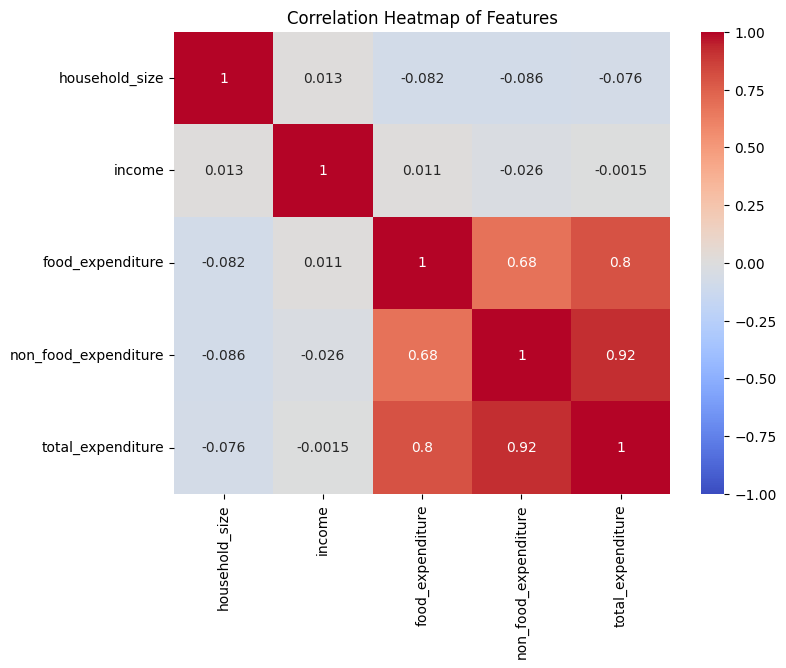

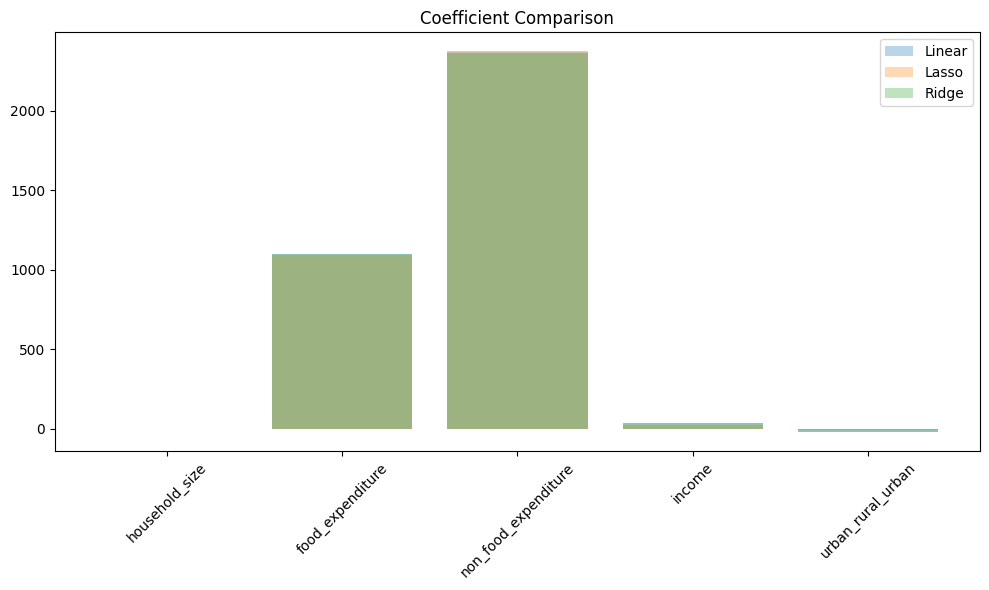

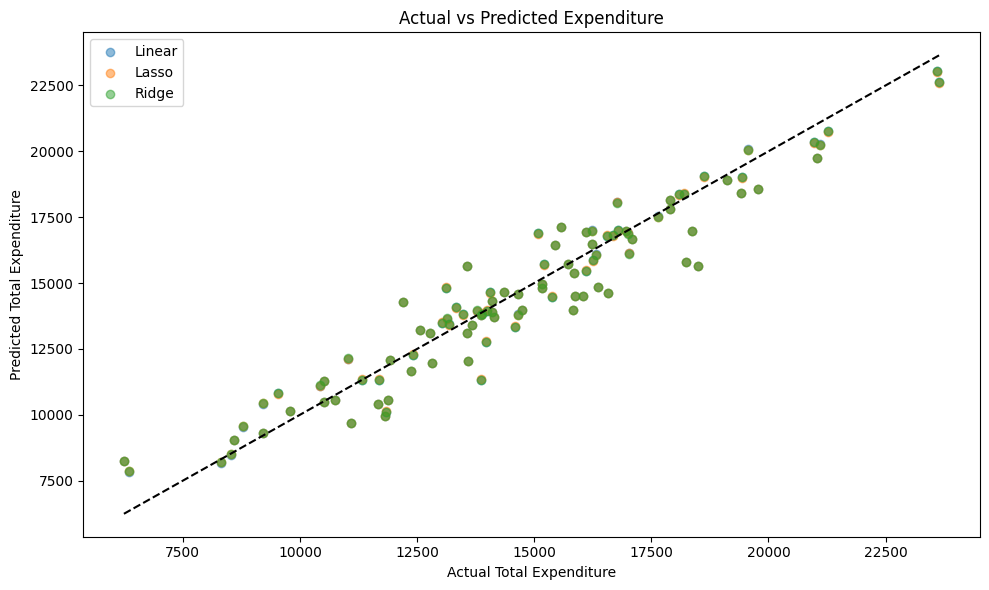

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plot correlation heatmap to show multicollinearity
plt.figure(figsize=(8, 6))
sns.heatmap(df.drop(columns=['urban_rural']).corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Features')
plt.show()

# Plot coefficients
plt.figure(figsize=(10, 6))
plt.bar(X.columns, lr.coef_, alpha=0.3, label='Linear')
plt.bar(X.columns, best_lasso.coef_, alpha=0.3, label='Lasso')
plt.bar(X.columns, best_ridge.coef_, alpha=0.3, label='Ridge')
plt.xticks(rotation=45)
plt.title('Coefficient Comparison')
plt.legend()
plt.tight_layout()
plt.show()

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, lr.predict(X_test), alpha=0.5, label='Linear')
plt.scatter(y_test, best_lasso.predict(X_test), alpha=0.5, label='Lasso')
plt.scatter(y_test, best_ridge.predict(X_test), alpha=0.5, label='Ridge')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('Actual Total Expenditure')
plt.ylabel('Predicted Total Expenditure')
plt.title('Actual vs Predicted Expenditure')
plt.legend()
plt.tight_layout()
plt.show()